In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [3]:
def factor_function(sigma_i, sigma_j, permutation, d):
    final = 1
    permutation = np.insert(permutation, 0, sigma_j)
    for j in range(d):
        if permutation[j]==1:
            if sigma_i + np.sum(permutation) - permutation[j] == 0:
                final *= 1
            else:
                final *= 0
        if final == 0:
            return 0
    return final

In [4]:
def BP(d, mu=0, tol=1e-12, max_iter=10000, damping_parameter=0.5, verbose=0, init_psi=None):
    psi=np.zeros((2,2))
    if init_psi is None:
        psi=np.random.uniform(size=(2,2))
        psi=psi/np.sum(psi)
    else:
        psi=init_psi.copy()
    
    permutations=np.array(list(itertools.product([0,1], repeat=d-1)))
    
    for t in range(max_iter):
        psi_new=np.zeros((2,2))
        for i in range(2):
            for j in range(2):
                for perm in permutations:
                    mult=1
                    if factor_function(i, j, perm, d)==0:
                        continue
                    for k in perm:
                        mult*=psi[k,i]
                    psi_new[i,j]+=np.exp(mu*i)*mult
                    
        if np.sum(psi_new)!=0:
            psi_new=psi_new/np.sum(psi_new)
        else:
            psi_new=np.array([[0.25, 0.25],[0.25, 0.25]])
        
        psi_new=damping_parameter*psi+(1-damping_parameter)*psi_new
        
        Delta=np.linalg.norm(psi_new-psi)
        if verbose==2 and t%100==0:
            print("Iter : ", t+1, " Delta : ", Delta)
        psi=psi_new
        if Delta<tol:
            break
    
    if t==max_iter-1:
        print("No convergence"+" ! Final error: "+ str(Delta))
    else:
        if verbose>=1:
            print("Converged ! Number of iteration "+str(t))
    
    return psi

In [5]:
def update_observables(psi, mu, d):
        phi_=0
        phi__=0
        permutations=np.array(list(itertools.product([0,1], repeat=d-1)))
        numerator=0
        for i in range(2):
            for j in range(2):
                for perm in permutations:
                    if factor_function(i, j, perm, d)==0:
                        continue
                    mult=psi[j,i]
                    for k in perm:
                        mult*=psi[k,i]
                    phi_+=np.exp(mu*i)*mult
                    numerator+=i*np.exp(mu*i)*mult
                phi__+=psi[i,j]*psi[j,i]

        if phi_==0:
            phi_=1e-16
        if phi__==0:
            phi__=1e-16
        phi=np.log(phi_)-d/2*np.log(phi__)

        if numerator==0:
            rho=0
        else:
            rho=numerator/phi_
            
        s=phi-mu*rho

        return phi, rho, s

##to confirm at the end
def density_numerical(phi_list, mu_list):
    N=phi_list.size
    rho=np.zeros(N-1)
    for i in range(N-1):
        rho[i]=(phi_list[i+1]-phi_list[i])/(mu_list[i+1]-mu_list[i])
    return rho

In [6]:
mu_space = np.linspace(-6, 12, 200)
d = 3
phi_list = []
rho_list = []
s_list = []
for mu in mu_space:
    psi = BP(d, mu=mu, verbose=0)
    phi, rho, s = update_observables(psi, mu, d)
    phi_list.append(phi)
    rho_list.append(rho)
    s_list.append(s)

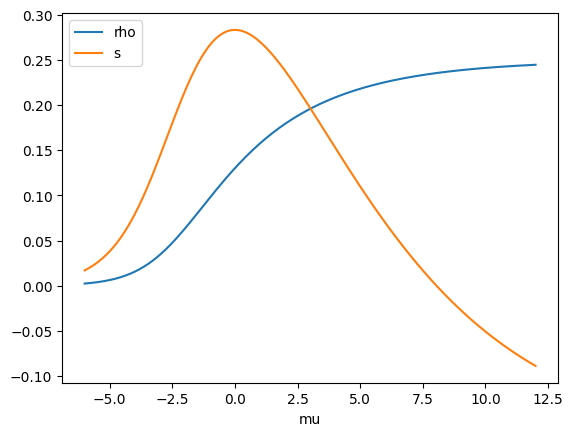

In [7]:
plt.plot(mu_space, rho_list, label='rho')
plt.plot(mu_space, s_list, label='s')
plt.xlabel('mu')
plt.legend()
plt.show()

In [8]:
def find_zero_bisection(arr):
    # Function to find zero using bisection method
    left = 0
    right = len(arr) - 1
    if(arr[left]*arr[right] > 0):
        print("No zero crossing found")
        return -1

    while right - left > 1:
        mid = (left + right) // 2
        if arr[mid] == 0:
            return mid  # Zero found at index 'mid'
        elif arr[mid] * arr[left] < 0:
            right = mid
        else:
            left = mid

    # If exact zero not found, return the index closest to zero
    return left if abs(arr[left]) < abs(arr[right]) else right

In [9]:
print(find_zero_bisection(s_list))

155


In [10]:
def complete_run(d, mu_space, verbose=0, max_iter=100000, damping_parameter=0.8):
    phi_list = []
    rho_list = []
    s_list = []
    for mu in mu_space:
        psi = BP(d, mu=mu, verbose=verbose, max_iter=max_iter, damping_parameter=damping_parameter)
        phi, rho, s = update_observables(psi, mu, d)
        phi_list.append(phi)
        rho_list.append(rho)
        s_list.append(s)

    zero_index = find_zero_bisection(s_list)
    if zero_index == -1:
        return -1
    return rho_list[zero_index]

In [29]:
d_list = [9, 10]
densest_packings = {}
mu_space = np.linspace(2, 10, 200)
for d in tqdm(d_list):
    densest_packings[d] = complete_run(d, mu_space)

100%|██████████| 2/2 [13:41<00:00, 410.74s/it]


In [30]:
print(densest_packings)

{9: 0.06496795358948015, 10: 0.056271843871893164}


In [15]:
densest_packings_1 = [0.4591, 0.4206, 0.3887, 0.3620, 0.3394, 0.3200, 0.3031, 0.2882]
densest_packings_2 = [0.2355, 0.1757, 0.1367, 0.1100, 0.0905, 0.0761, 0.0650, 0.0563]
degree = [3,4,5,6,7,8,9,10]
comparison = []
comparison_2 = []
subtract = densest_packings_1[0]-densest_packings_2[0]
for idx, d in enumerate(degree):
    comparison.append(densest_packings_1[idx]/d)
    comparison_2.append(densest_packings_1[idx]-subtract)

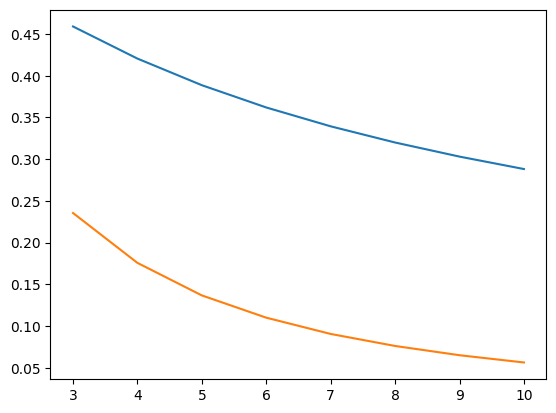

In [4]:
plt.plot(degree, densest_packings_1, label='Distance 1')
plt.plot(degree, densest_packings_2, label='Distance 2')

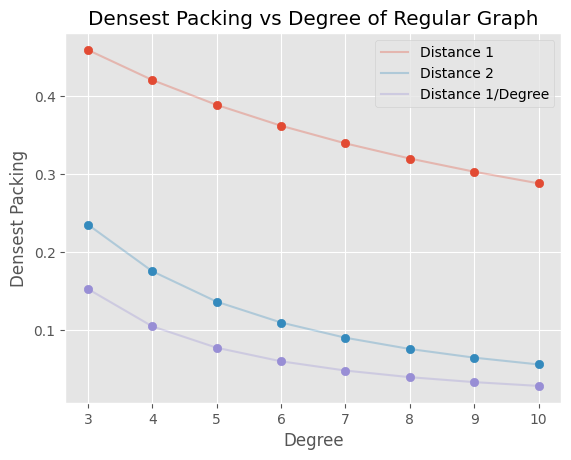

<Figure size 640x480 with 0 Axes>

In [13]:
plt.style.use('ggplot')

plt.scatter(degree, densest_packings_1)
plt.plot(degree, densest_packings_1, alpha=0.3, label='Distance 1'   )

plt.scatter(degree, densest_packings_2)
plt.plot(degree, densest_packings_2, alpha=0.3, label='Distance 2')

plt.scatter(degree, comparison)
plt.plot(degree, comparison, alpha=0.3, label='Distance 1/Degree')

plt.xlabel('Degree')
plt.ylabel('Densest Packing')
plt.title('Densest Packing vs Degree of Regular Graph')
plt.legend()
plt.savefig('densest_packings.png')
plt.show()
plt.savefig('densest_packings.png')


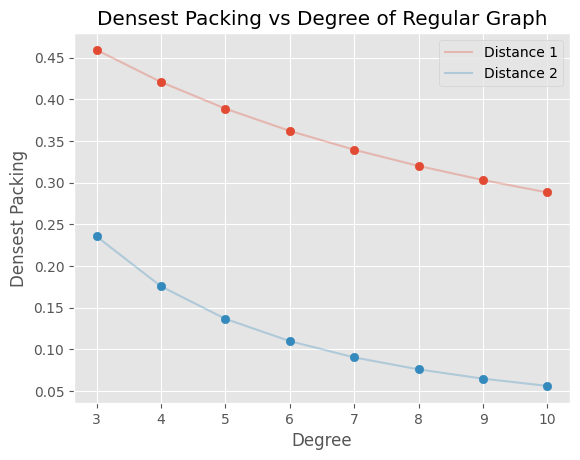

<Figure size 640x480 with 0 Axes>

In [14]:
plt.style.use('ggplot')

plt.scatter(degree, densest_packings_1)
plt.plot(degree, densest_packings_1, alpha=0.3, label='Distance 1')

plt.scatter(degree, densest_packings_2)
plt.plot(degree, densest_packings_2, alpha=0.3, label='Distance 2')


plt.xlabel('Degree')
plt.ylabel('Densest Packing')
plt.title('Densest Packing vs Degree of Regular Graph')
plt.legend()
plt.savefig('densest_packings.png')
plt.show()
plt.savefig('densest_packings.png')

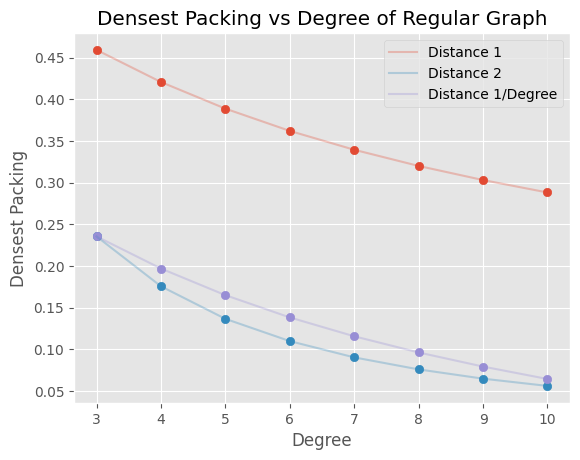

<Figure size 640x480 with 0 Axes>

In [18]:
plt.style.use('ggplot')

plt.scatter(degree, densest_packings_1)
plt.plot(degree, densest_packings_1, alpha=0.3, label='Distance 1'   )

plt.scatter(degree, densest_packings_2)
plt.plot(degree, densest_packings_2, alpha=0.3, label='Distance 2')

plt.scatter(degree, comparison_2)
plt.plot(degree, comparison_2, alpha=0.3, label='Distance 1/Degree')

plt.xlabel('Degree')
plt.ylabel('Densest Packing')
plt.title('Densest Packing vs Degree of Regular Graph')
plt.legend()
plt.savefig('densest_packings.png')
plt.show()
plt.savefig('densest_packings.png')